In [ ]:
# Installing necessary packages
!pip install keras-tuner

# Importing necessary libraries
import os
import glob
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from xgboost import XGBClassifier

import keras
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.models import load_model, save_model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization


/var/folders/bp/pzmg_4bx0kxc4_jr5p1npj1h0000gn/T/ipykernel_15245/2416610556.py:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


# Data Pre-Processing

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Load the dataset
df = pd.read_csv('liberman_manor_marcotti.csv')
df.filename = df.filename.astype(str)

grouped = df.groupby(['filename', 'Freq(Hz)'])

# Remove rows with specific filenames
exclude_filenames = ['17', '48', '55', '71', '74', '80', '81', '91', '100', '103', 'WPZ142', 'WPZ173']
df = df[~df['filename'].isin(exclude_filenames)]


/var/folders/bp/pzmg_4bx0kxc4_jr5p1npj1h0000gn/T/ipykernel_15245/2039990552.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('liberman_manor_marcotti.csv')


In [ ]:
# Create a unique identifier for each file-frequency combination
df['file_freq'] = df['filename'].astype(str) + df['Freq(Hz)'].astype(str)
unique_file_freq = df['file_freq'].unique()

# Create the masks for different labs
manor_mask = df['lab'] == 'manor'
marcotti_mask = df['lab'] == 'marcotti'
liberman_mask = df['lab'] == 'liberman'

# Apply the masks to split the data by lab
manor_data = df[manor_mask]
marcotti_data = df[marcotti_mask]
liberman_data = df[liberman_mask]

# Define a function to split data into train and test sets
def split_data(data):
    unique_mice = data['mouse'].unique()
    train_mice, test_mice = train_test_split(unique_mice, test_size=0.2, random_state=42)
    train = data[data['mouse'].isin(train_mice)]
    test = data[data['mouse'].isin(test_mice)]
    return train, test

# Split each lab's data into train and test sets
manor_train, manor_test = split_data(manor_data)
marcotti_train, marcotti_test = split_data(marcotti_data)
liberman_train, liberman_test = split_data(liberman_data)

# Combine the training and testing sets from all labs
train = pd.concat([liberman_train, marcotti_train, manor_train])
test = pd.concat([liberman_test, marcotti_test, manor_test])

train, val = split_data(train)

def assign_weights(df):
    lab_counts = df['lab'].value_counts()
    weights = {lab: 1.0 / count for lab, count in lab_counts.items()}
    df['sample_weight'] = df['lab'].map(weights)
    return df

train = assign_weights(train)
val = assign_weights(val)

# Function to normalize each group by 'file_freq'
wave_cols = [str(i) for i in range(0, 244)]
def normalize_group(group):
    try:
        data_to_scale = group[wave_cols]
    except KeyError:
        print("KeyError: One of the specified columns does not exist in the DataFrame.")

    # Flatten the data to scale all values across the group
    flattened_data = data_to_scale.values.flatten().reshape(-1, 1)
    min_max_scaler = MinMaxScaler(feature_range=(0, 1)) 
    scaled_data = min_max_scaler.fit_transform(flattened_data).reshape(data_to_scale.shape)

    # Reshape back to the original shape and update the group
    group[data_to_scale.columns] = scaled_data

    return group

# Apply normalization function to each 'file_freq' group
train = train.groupby('file_freq').apply(normalize_group)
val = val.groupby('file_freq').apply(normalize_group)
test = test.groupby('file_freq').apply(normalize_group)

X_train = np.expand_dims(train[wave_cols].values, axis=2)
y_train = np.array(train['Hearing'])

X_val = np.expand_dims(val[wave_cols].values, axis=2)
y_val = np.array(val['Hearing'])

X_test = np.expand_dims(test[wave_cols].values, axis=2)
y_test = np.array(test['Hearing'])


In [ ]:
# Define a function to apply noise injection
def add_noise(data, noise_percentage=0.05):
    # Calculate noise based on a percentage of each data point's value
    noise = noise_percentage * data * np.random.randn(*data.shape)
    
    # Add the calculated noise to the original data
    augmented_data = data + noise
    
    return augmented_data

# Define a function to apply time warping
def time_warp(data, sigma=0.2):
    from scipy.interpolate import CubicSpline
    
    original_time_steps = np.arange(data.shape[1])
    random_points = np.random.normal(loc=original_time_steps, scale=sigma)
    random_points = np.sort(random_points)
    
    warped_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        cs = CubicSpline(original_time_steps, data[i, :, 0])
        warped_data[i, :, 0] = cs(random_points)
    return warped_data

# Define a function to apply scaling
def random_scaling(data, scaling_factor_range=(0.8, 1.2)):
    scaling_factors = np.random.uniform(scaling_factor_range[0], scaling_factor_range[1], (data.shape[0], 1))
    scaled_data = data * scaling_factors[:, np.newaxis]
    return scaled_data

# Function to perform time shifting
def time_shift(data, shift_max=5, noise_percentage=0.05):
    shifted_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        shift = np.random.randint(-shift_max, shift_max)
        
        # Set noise_level proportional to the first point value
        first_point_value = data[i, 0, 0]
        noise_level = noise_percentage * abs(first_point_value)
        
        if shift > 0:
            # Shift right: fill the start with noise around the first point
            shifted_data[i, shift:, 0] = data[i, :-shift, 0]  # Shift right
            noise = np.random.normal(loc=first_point_value, scale=noise_level, size=shift)
            shifted_data[i, :shift, 0] = noise
            
        elif shift < 0:
            # Shift left: fill the end with noise around the first point
            shifted_data[i, :shift, 0] = data[i, -shift:, 0]  # Shift left
            noise = np.random.normal(loc=first_point_value, scale=noise_level, size=-shift)
            shifted_data[i, shift:, 0] = noise
            
        else:
            # No shift: keep the data unchanged
            shifted_data[i, :, 0] = data[i, :, 0]
            
    return shifted_data

# Example of applying augmentation to the training data
augmented_X_train = np.copy(X_train)
augmented_X_train = add_noise(augmented_X_train, noise_percentage=0.04)
augmented_X_train = time_warp(augmented_X_train, sigma = 3.0)
#augmented_X_train = random_scaling(augmented_X_train, scaling_factor_range=(0.9, 1.1))
augmented_X_train = time_shift(augmented_X_train, shift_max=18)

# You can now combine the original data with the augmented data
X_train_cnn_augmented = np.concatenate((X_train, augmented_X_train), axis=0)
y_train_augmented = np.concatenate((y_train, y_train), axis=0)

# Adjust sample weights: repeat the original weights for the augmented data
sample_weights_train = np.array(train['sample_weight'])
sample_weights_train = np.concatenate([sample_weights_train, sample_weights_train])

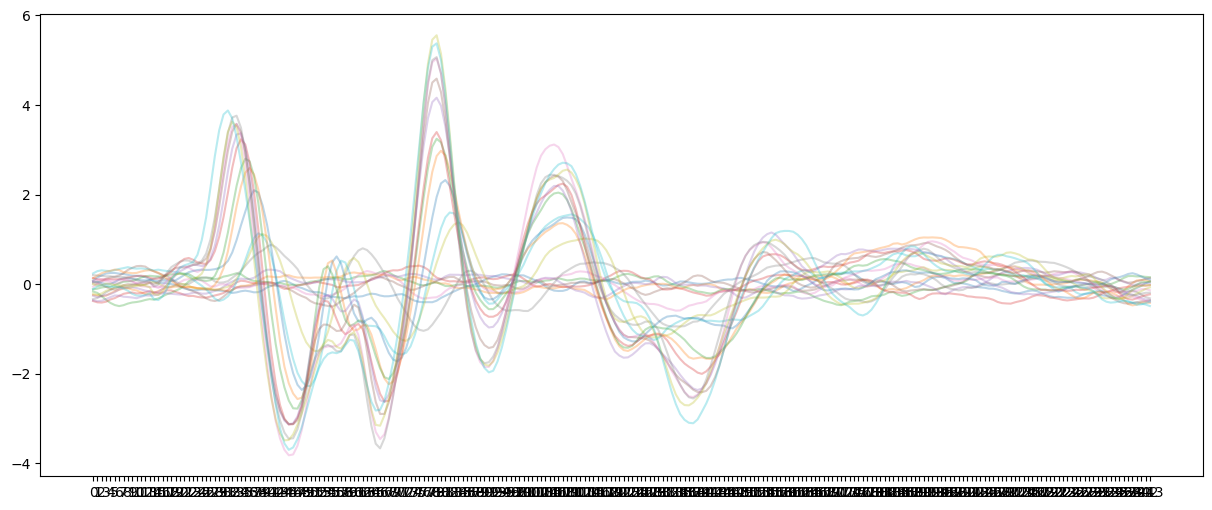

In [6]:
plt.figure(figsize=(15, 6))

# Iterate through each row and plot the data
i=0
for index, row in train.loc[:, '0':'243'].iterrows():
    plt.plot(row, alpha=0.3)
    i+=1
    if i == 20:
        break

# Model Training

In [ ]:
class WeightedValidationLoss(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val, sample_weights_val):
        self.X_val = X_val
        self.y_val = y_val.reshape(-1, 1)  # Ensure correct shape
        self.sample_weights_val = sample_weights_val

    def on_epoch_end(self, epoch, logs=None):
        val_preds = self.model.predict(self.X_val, verbose=0)
        val_preds = val_preds.reshape(-1, 1)  # Ensure same shape as y_val

        val_loss = tf.keras.losses.binary_crossentropy(self.y_val, val_preds)
        weighted_val_loss = tf.reduce_mean(val_loss * self.sample_weights_val)  # Apply sample weights
        logs['val_loss'] = weighted_val_loss.numpy()  # Overwrite val_loss in logs

In [ ]:
rlrop_patience=20
filters_3=64
learning_rate=0.0001
filters_2=128
dropout_rate2=0.4
kernel_size=7
pool_size=2
earlystop_patience=25
batch_size=128
rlrop_factor=0.5
filters_1=128
dropout_rate=0.5

early_stopping = EarlyStopping(monitor='val_loss', patience=earlystop_patience, restore_best_weights=True)
callbacks = [WeightedValidationLoss(X_val, y_val, np.array(val['sample_weight'])), early_stopping, ]

if rlrop_factor is not None:
    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=rlrop_factor, patience=rlrop_patience, verbose=1, min_lr=1e-6)
    callbacks.append(lr_scheduler)

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Define CNN architecture
model = Sequential([
    Conv1D(filters=filters_1, kernel_size=kernel_size, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=pool_size),
    Dropout(dropout_rate),

    Conv1D(filters=filters_2, kernel_size=kernel_size, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=pool_size),
    Dropout(dropout_rate),

    Conv1D(filters=filters_3, kernel_size=kernel_size, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=pool_size),
    Dropout(dropout_rate),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rate2),

    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.fit(
    X_train_cnn_augmented, y_train_augmented,
    validation_data=(X_val, y_val),  
    epochs=1000,
    batch_size=batch_size,
    callbacks=callbacks,
    sample_weight=sample_weights_train,  
    verbose=1
)

Epoch 1/1000
866/866 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.7982 - loss: 7.1407e-05 - val_accuracy: 0.8635 - val_loss: 5.5113e-05
Epoch 2/1000
866/866 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9057 - loss: 4.3379e-05 - val_accuracy: 0.8763 - val_loss: 5.3786e-05
Epoch 3/1000
866/866 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.9108 - loss: 3.7596e-05 - val_accuracy: 0.9042 - val_loss: 4.3169e-05
Epoch 4/1000
866/866 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.9233 - loss: 3.3855e-05 - val_accuracy: 0.9035 - val_loss: 4.4160e-05
Epoch 5/1000
866/866 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.9241 - loss: 3.0858e-05 - val_accuracy: 0.8945 - val_loss: 4.5031e-05
Epoch 6/1000
866/866 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.9324 - loss: 2.8402e-05 - val_accuracy: 0.9117 - val_loss: 4.0428e-05
Epoch 7/1000
866/866 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.9307 - loss: 2.7854e-05 - val_accuracy: 0.9100 - val_loss: 4.0131e-05
Epoch 8/1000
866/866

In [ ]:
# Evaluate the model on the test data and print the accuracy
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9591 - loss: 0.1203
Accuracy: 94.67


In [14]:
save_model(model, './abr_cnn_aug_norm_opt.keras')

In [3]:
model = load_model('./abr_cnn_aug_norm_opt.keras')

## Manor Lab Metrics

In [11]:
mask = train['filename'].apply(lambda x: len(str(x)) > 9)
manor_train = train[mask]
print(len(manor_train))

5318


In [12]:
len(set([s for s in manor_train['filename'].unique()]))

110

In [13]:
mask = test['filename'].apply(lambda x: len(str(x)) > 9)
manor_test = test[mask]
print(len(manor_test))

1329


In [14]:
len(set([s for s in manor_test['filename'].unique()]))

73

In [15]:
X_manor_test = manor_test.drop(columns=['Hearing', 'filename', 'file_freq', 'Freq(Hz)', 'Level(dB)'])
X_manor_test_cnn = np.expand_dims(X_manor_test.values, axis=2)
y_manor_test = np.array(manor_test['Hearing'])

In [16]:
# Evaluate the model on the test data and print the accuracy
_, accuracy = model.evaluate(X_manor_test_cnn, y_manor_test)
print('Accuracy: %.2f' % (accuracy*100))

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9120 - loss: 0.2364
Accuracy: 90.90


In [17]:
# Predictions
y_pred_test = (model.predict(X_manor_test_cnn) > 0.5).astype(int)

# Add predictions to test data
test_data_with_predictions = manor_test.assign(prediction=y_pred_test)[['filename', 'prediction', 'Hearing', 'Freq(Hz)', 'Level(dB)']]

# Calculate thresholds
# Logic 1
thresholds = []
for (filename, freq), group in test_data_with_predictions.groupby(['filename', 'Freq(Hz)']):
    group = group.sort_values('Level(dB)', ascending=True)
    ground_truth_threshold = group[group['Hearing'] == 1]['Level(dB)'].min()
    
    lowest_db = None
    previous_prediction = None

    for i, (p, d) in enumerate(zip(group['prediction'], group['Level(dB)'])):
        if p == 0:
            lowest_db = d
            previous_prediction = p
        else:
            if previous_prediction == 1:
                predicted_threshold = lowest_db
                break  # Break if two consecutive `1`s are encountered
            lowest_db = d
            previous_prediction = p

    thresholds.append({
        'filename': filename,
        'Freq(Hz)': freq,
        'predicted_threshold': predicted_threshold,
        'ground_truth_threshold': ground_truth_threshold,
        'Lab': 'Manor',
        'Logic': 'Robust Bottom-Up'
    })

# Prepare thresholds dataframe
thresholds = pd.DataFrame(thresholds)
thresholds['diff'] = np.abs(thresholds['predicted_threshold'] - thresholds['ground_truth_threshold'])

# Calculate percentages
within_db_percentages = {db: (thresholds['diff'] <= db).mean() * 100 for db in [0, 5, 10, 15]}
for db, percentage in within_db_percentages.items():
    print(f'Within {db} db: {percentage}%')

# Print mean difference
print(thresholds['diff'].mean())
print(thresholds['diff'].std()/np.sqrt(len(thresholds)))


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Within 0 db: 37.5%
Within 5 db: 73.07692307692307%
Within 10 db: 89.42307692307693%
Within 15 db: 93.26923076923077%
5.865384615384615
0.7403924958117224


In [18]:
# Predictions
y_pred_test = (model.predict(X_manor_test_cnn) > 0.5).astype(int)

# Add predictions to test data
test_data_with_predictions = manor_test.assign(prediction=y_pred_test)[['filename', 'prediction', 'Hearing', 'Freq(Hz)', 'Level(dB)']]

# Calculate thresholds
# Logic 2
new_thresholds = []
for (filename, freq), group in test_data_with_predictions.groupby(['filename', 'Freq(Hz)']):
    group = group.sort_values('Level(dB)', ascending=False)
    ground_truth_threshold = group[group['Hearing'] == 1]['Level(dB)'].min()
    
    lowest_db = np.max(group['Level(dB)'])
    previous_prediction = None

    for i, (p, d) in enumerate(zip(group['prediction'], group['Level(dB)'])):
        if p == 0:
            predicted_threshold = lowest_db
            break
        else:
            lowest_db = d
            previous_prediction = p
    predicted_threshold = lowest_db

    new_thresholds.append({
        'filename': filename,
        'Freq(Hz)': freq,
        'predicted_threshold': predicted_threshold,
        'ground_truth_threshold': ground_truth_threshold,
        'Lab': 'Manor',
        'Logic': 'Naive Top-Down'
    })

# Prepare thresholds dataframe
new_thresholds = pd.DataFrame(new_thresholds)
new_thresholds['diff'] = np.abs(new_thresholds['predicted_threshold'] - new_thresholds['ground_truth_threshold'])
thresholds = pd.concat([thresholds, new_thresholds])

# Calculate percentages
within_db_percentages = {db: (thresholds['diff'] <= db).mean() * 100 for db in [0, 5, 10, 15]}
for db, percentage in within_db_percentages.items():
    print(f'Within {db} db: {percentage}%')

# Print mean difference
print(new_thresholds['diff'].mean())
print(new_thresholds['diff'].std()/np.sqrt(len(new_thresholds)))

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Within 0 db: 38.46153846153847%
Within 5 db: 75.0%
Within 10 db: 91.34615384615384%
Within 15 db: 95.1923076923077%
4.711538461538462
0.5012443583912899


In [19]:
# Calculate thresholds
# Logic 3: Naive Bottom-Up
new_thresholds = []
for (filename, freq), group in test_data_with_predictions.groupby(['filename', 'Freq(Hz)']):
    group = group.sort_values('Level(dB)', ascending=True)
    ground_truth_threshold = group[group['Hearing'] == 1]['Level(dB)'].min()
    
    lowest_db = None
    for i, (p, d) in enumerate(zip(group['prediction'], group['Level(dB)'])):
        if p == 1:
            lowest_db = d
            break  # Stop as soon as we find the first `1`

    new_thresholds.append({
        'filename': filename,
        'Freq(Hz)': freq,
        'predicted_threshold': lowest_db,
        'ground_truth_threshold': ground_truth_threshold,
        'Lab': 'Manor',
        'Logic': 'Naive Bottom-Up'
    })

# Prepare thresholds dataframe
new_thresholds = pd.DataFrame(new_thresholds)
new_thresholds['diff'] = np.abs(new_thresholds['predicted_threshold'] - new_thresholds['ground_truth_threshold'])
thresholds = pd.concat([thresholds, new_thresholds])

# Calculate percentages
within_db_percentages = {db: (thresholds['diff'] <= db).mean() * 100 for db in [0, 5, 10, 15]}
for db, percentage in within_db_percentages.items():
    print(f'Within {db} db: {percentage}%')

# Print mean difference
print(new_thresholds['diff'].mean())
print(new_thresholds['diff'].std()/np.sqrt(len(new_thresholds)))

Within 0 db: 36.858974358974365%
Within 5 db: 73.07692307692307%
Within 10 db: 90.7051282051282%
Within 15 db: 94.55128205128204%
5.970873786407767
0.6728768506653461


In [20]:
# Calculate thresholds
# Logic 4: Robust Top-Down
new_thresholds = []
for (filename, freq), group in test_data_with_predictions.groupby(['filename', 'Freq(Hz)']):
    group = group.sort_values('Level(dB)', ascending=False)
    ground_truth_threshold = group[group['Hearing'] == 1]['Level(dB)'].min()
    
    lowest_db = np.max(group['Level(dB)'])
    previous_prediction = None

    for i, (p, d) in enumerate(zip(group['prediction'], group['Level(dB)'])):
        if p == 1:
            if previous_prediction == 1:
                lowest_db = d
                break  # Stop only when two consecutive `1`s are found
            previous_prediction = p
        else:
            previous_prediction = p

    new_thresholds.append({
        'filename': filename,
        'Freq(Hz)': freq,
        'predicted_threshold': lowest_db,
        'ground_truth_threshold': ground_truth_threshold,
        'Lab': 'Manor',
        'Logic': 'Robust Top-Down'
    })

# Prepare thresholds dataframe
new_thresholds = pd.DataFrame(new_thresholds)
new_thresholds['diff'] = np.abs(new_thresholds['predicted_threshold'] - new_thresholds['ground_truth_threshold'])
thresholds = pd.concat([thresholds, new_thresholds])

# Calculate percentages
within_db_percentages = {db: (thresholds['diff'] <= db).mean() * 100 for db in [0, 5, 10, 15]}
for db, percentage in within_db_percentages.items():
    print(f'Within {db} db: {percentage}%')

# Print mean difference
print(new_thresholds['diff'].mean())
print(new_thresholds['diff'].std()/np.sqrt(len(new_thresholds)))

Within 0 db: 28.60576923076923%
Within 5 db: 57.692307692307686%
Within 10 db: 73.07692307692307%
Within 15 db: 78.60576923076923%
29.326923076923077
1.7378857509737793


In [21]:
len(test_data_with_predictions.groupby(['filename', 'Freq(Hz)']))

104

In [22]:
#TPR/FRR METRICS

df = test_data_with_predictions
tn, fp, fn, tp = confusion_matrix(df['Hearing'], df['prediction']).ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
print(f"True Positive Rate (TPR): {tpr}")
print(f"False Positive Rate (FPR): {fpr}")


True Positive Rate (TPR): 0.9089805825242718
False Positive Rate (FPR): 0.09108910891089109


In [23]:
# AUCROC/AUCPR
from sklearn.metrics import roc_auc_score, average_precision_score
df = test_data_with_predictions
auc_roc = roc_auc_score(df['Hearing'], df['prediction'])
auc_pr = average_precision_score(df['Hearing'], df['prediction'])
print(f"AUC-ROC: {auc_roc}")
print(f"AUC-PR: {auc_pr}")


AUC-ROC: 0.9089457368066904
AUC-PR: 0.9128188882139532


In [24]:
len(manor_test)

1329

## Marcotti Lab Metrics

In [25]:
mask = train['filename'].apply(lambda x: len(str(x)) <= 3)
marcotti_train = train[mask]
print(len(marcotti_train))

11698


In [26]:
len(set([str(s).split()[0] for s in marcotti_train['filename'].unique()]))

94

In [27]:
mask = test['filename'].apply(lambda x: len(str(x)) <= 3)
marcotti_test = test[mask]
print(len(marcotti_test))

2966


In [28]:
len(set([str(s).split()[0] for s in marcotti_test['filename'].unique()]))

85

In [29]:
X_marcotti_test = marcotti_test.drop(columns=['Hearing', 'filename', 'file_freq', 'Freq(Hz)', 'Level(dB)'])
X_marcotti_test_cnn = np.expand_dims(X_marcotti_test.values, axis=2)
y_marcotti_test = np.array(marcotti_test['Hearing'])

In [30]:
# Evaluate the model on the test data and print the accuracy
_, accuracy = model.evaluate(X_marcotti_test_cnn, y_marcotti_test)
print('Accuracy: %.2f' % (accuracy*100))

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9613 - loss: 0.1122
Accuracy: 96.43


In [31]:
# Predictions
y_pred_test = (model.predict(X_marcotti_test_cnn) > 0.5).astype(int)

# Add predictions to test data
test_data_with_predictions = marcotti_test.assign(prediction=y_pred_test)[['filename', 'prediction', 'Hearing', 'Freq(Hz)', 'Level(dB)']]

# Calculate thresholds
# Logic 1
new_thresholds = []
for (filename, freq), group in test_data_with_predictions.groupby(['filename', 'Freq(Hz)']):
    group = group.sort_values('Level(dB)', ascending=True)
    ground_truth_threshold = group[group['Hearing'] == 1]['Level(dB)'].min()
    
    lowest_db = None
    previous_prediction = None

    for i, (p, d) in enumerate(zip(group['prediction'], group['Level(dB)'])):
        if p == 0:
            lowest_db = d
            previous_prediction = p
        else:
            if previous_prediction == 1:
                predicted_threshold = lowest_db
                break  # Break if two consecutive `1`s are encountered
            lowest_db = d
            previous_prediction = p

    new_thresholds.append({
        'filename': filename,
        'Freq(Hz)': freq,
        'predicted_threshold': predicted_threshold,
        'ground_truth_threshold': ground_truth_threshold,
        'Lab': 'Marcotti',
        'Logic': 'Robust Bottom-Up'
    })

# Prepare thresholds dataframe
new_thresholds = pd.DataFrame(new_thresholds)
new_thresholds['diff'] = np.abs(new_thresholds['predicted_threshold'] - new_thresholds['ground_truth_threshold'])
thresholds = pd.concat([thresholds, new_thresholds])

# Calculate percentages
within_db_percentages = {db: (thresholds['diff'] <= db).mean() * 100 for db in [0, 5, 10, 15]}
for db, percentage in within_db_percentages.items():
    print(f'Within {db} db: {percentage}%')

# Print mean difference
print(new_thresholds['diff'].mean())
print(new_thresholds['diff'].std()/np.sqrt(len(new_thresholds)))

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Within 0 db: 36.734693877551024%
Within 5 db: 67.85714285714286%
Within 10 db: 79.93197278911565%
Within 15 db: 84.35374149659864%
3.0813953488372094
0.4634345019974803


In [32]:
len(test_data_with_predictions.groupby(['filename', 'Freq(Hz)']))

172

In [33]:
# Predictions
y_pred_test = (model.predict(X_marcotti_test_cnn) > 0.5).astype(int)

# Add predictions to test data
test_data_with_predictions = marcotti_test.assign(prediction=y_pred_test)[['filename', 'prediction', 'Hearing', 'Freq(Hz)', 'Level(dB)']]

# Calculate thresholds
# Logic 2
new_thresholds = []
for (filename, freq), group in test_data_with_predictions.groupby(['filename', 'Freq(Hz)']):
    group = group.sort_values('Level(dB)', ascending=False)
    ground_truth_threshold = group[group['Hearing'] == 1]['Level(dB)'].min()
    
    lowest_db = np.max(group['Level(dB)'])
    previous_prediction = None

    for i, (p, d) in enumerate(zip(group['prediction'], group['Level(dB)'])):
        if p == 0:
            predicted_threshold = lowest_db
            break
        else:
            lowest_db = d
            previous_prediction = p

    new_thresholds.append({
        'filename': filename,
        'Freq(Hz)': freq,
        'predicted_threshold': predicted_threshold,
        'ground_truth_threshold': ground_truth_threshold,
        'Lab': 'Marcotti',
        'Logic': 'Naive Top-Down'
    })

# Prepare thresholds dataframe
new_thresholds = pd.DataFrame(new_thresholds)
new_thresholds['diff'] = np.abs(new_thresholds['predicted_threshold'] - new_thresholds['ground_truth_threshold'])
thresholds = pd.concat([thresholds, new_thresholds])

# Calculate percentages
within_db_percentages = {db: (thresholds['diff'] <= db).mean() * 100 for db in [0, 5, 10, 15]}
for db, percentage in within_db_percentages.items():
    print(f'Within {db} db: {percentage}%')

# Print mean difference
print(new_thresholds['diff'].mean())
print(new_thresholds['diff'].std()/np.sqrt(len(new_thresholds)))

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Within 0 db: 40.921052631578945%
Within 5 db: 72.5%
Within 10 db: 82.89473684210526%
Within 15 db: 86.8421052631579%
3.7209302325581395
0.4954095222084219


In [34]:
# Calculate thresholds
# Logic 3: Naive Bottom-Up
new_thresholds = []
for (filename, freq), group in test_data_with_predictions.groupby(['filename', 'Freq(Hz)']):
    group = group.sort_values('Level(dB)', ascending=True)
    ground_truth_threshold = group[group['Hearing'] == 1]['Level(dB)'].min()
    
    lowest_db = None
    for i, (p, d) in enumerate(zip(group['prediction'], group['Level(dB)'])):
        if p == 1:
            lowest_db = d
            break  # Stop as soon as we find the first `1`

    new_thresholds.append({
        'filename': filename,
        'Freq(Hz)': freq,
        'predicted_threshold': lowest_db,
        'ground_truth_threshold': ground_truth_threshold,
        'Lab': 'Marcotti',
        'Logic': 'Naive Bottom-Up'
    })

# Prepare thresholds dataframe
new_thresholds = pd.DataFrame(new_thresholds)
new_thresholds['diff'] = np.abs(new_thresholds['predicted_threshold'] - new_thresholds['ground_truth_threshold'])
thresholds = pd.concat([thresholds, new_thresholds])

# Calculate percentages
within_db_percentages = {db: (thresholds['diff'] <= db).mean() * 100 for db in [0, 5, 10, 15]}
for db, percentage in within_db_percentages.items():
    print(f'Within {db} db: {percentage}%')

# Print mean difference
print(new_thresholds['diff'].mean())
print(new_thresholds['diff'].std()/np.sqrt(len(new_thresholds)))
# Calculate thresholds
# Logic 4: Robust Top-Down
new_thresholds = []
for (filename, freq), group in test_data_with_predictions.groupby(['filename', 'Freq(Hz)']):
    group = group.sort_values('Level(dB)', ascending=False)
    ground_truth_threshold = group[group['Hearing'] == 1]['Level(dB)'].min()
    
    lowest_db = np.max(group['Level(dB)'])
    previous_prediction = None

    for i, (p, d) in enumerate(zip(group['prediction'], group['Level(dB)'])):
        if p == 1:
            if previous_prediction == 1:
                lowest_db = d
                break  # Stop only when two consecutive `1`s are found
            previous_prediction = p
        else:
            previous_prediction = p

    new_thresholds.append({
        'filename': filename,
        'Freq(Hz)': freq,
        'predicted_threshold': lowest_db,
        'ground_truth_threshold': ground_truth_threshold,
        'Lab': 'Marcotti',
        'Logic': 'Robust Top-Down'
    })

# Prepare thresholds dataframe
new_thresholds = pd.DataFrame(new_thresholds)
new_thresholds['diff'] = np.abs(new_thresholds['predicted_threshold'] - new_thresholds['ground_truth_threshold'])
thresholds = pd.concat([thresholds, new_thresholds])

# Calculate percentages
within_db_percentages = {db: (thresholds['diff'] <= db).mean() * 100 for db in [0, 5, 10, 15]}
for db, percentage in within_db_percentages.items():
    print(f'Within {db} db: {percentage}%')

# Print mean difference
print(new_thresholds['diff'].mean())
print(new_thresholds['diff'].std()/np.sqrt(len(new_thresholds)))

Within 0 db: 43.13304721030043%
Within 5 db: 75.0%
Within 10 db: 84.76394849785407%
Within 15 db: 88.62660944206009%
3.888888888888889
0.5275867447328585
Within 0 db: 36.5036231884058%
Within 5 db: 63.677536231884055%
Within 10 db: 72.19202898550725%
Within 15 db: 75.81521739130434%
49.68023255813954
1.275593594281336


In [35]:
#TPR/FRR METRICS

df = test_data_with_predictions
tn, fp, fn, tp = confusion_matrix(df['Hearing'], df['prediction']).ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
print(f"True Positive Rate (TPR): {tpr}")
print(f"False Positive Rate (FPR): {fpr}")


True Positive Rate (TPR): 0.9878108239882983
False Positive Rate (FPR): 0.08852459016393442


In [36]:
# AUCROC/AUCPR
from sklearn.metrics import roc_auc_score, average_precision_score
df = test_data_with_predictions
auc_roc = roc_auc_score(df['Hearing'], df['prediction'])
auc_pr = average_precision_score(df['Hearing'], df['prediction'])
print(f"AUC-ROC: {auc_roc}")
print(f"AUC-PR: {auc_pr}")


AUC-ROC: 0.949643116912182
AUC-PR: 0.9582649920745938


## Liberman Lab Metrics

In [37]:
mask = train['filename'].apply(lambda x: len(str(x)) > 3 and len(str(x)) < 9)
liberman_train = train[mask]
print(len(liberman_train))

289


In [38]:
len(set([s.split()[0] for s in liberman_train['filename'].unique()]))

6

In [39]:
mask = test['filename'].apply(lambda x: len(str(x)) > 3 and len(str(x)) < 9)
liberman_test = test[mask]
print(len(liberman_test))

76


In [40]:
len(set([s.split()[0] for s in liberman_test['filename'].unique()]))

4

In [41]:
X_liberman_test = liberman_test.drop(columns=['Hearing', 'filename', 'file_freq', 'Freq(Hz)', 'Level(dB)'])
X_liberman_test_cnn = np.expand_dims(X_liberman_test.values, axis=2)
y_liberman_test = np.array(liberman_test['Hearing'])

In [42]:
# Evaluate the model on the test data and print the accuracy
_, accuracy = model.evaluate(X_liberman_test_cnn, y_liberman_test)
print('Accuracy: %.2f' % (accuracy*100))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9058 - loss: 0.3065 
Accuracy: 92.11


In [43]:
# Predictions
y_pred_test = (model.predict(X_liberman_test_cnn) > 0.5).astype(int)

# Add predictions to test data
test_data_with_predictions = liberman_test.assign(prediction=y_pred_test)[['filename', 'prediction', 'Hearing', 'Freq(Hz)', 'Level(dB)']]

# Calculate thresholds
# Logic 1
new_thresholds = []
for (filename, freq), group in test_data_with_predictions.groupby(['filename', 'Freq(Hz)']):
    group = group.sort_values('Level(dB)', ascending=True)
    ground_truth_threshold = group[group['Hearing'] == 1]['Level(dB)'].min()
    
    lowest_db = None
    previous_prediction = None

    for i, (p, d) in enumerate(zip(group['prediction'], group['Level(dB)'])):
        if p == 0:
            lowest_db = d
            previous_prediction = p
        else:
            if previous_prediction == 1:
                predicted_threshold = lowest_db
                break  # Break if two consecutive `1`s are encountered
            lowest_db = d
            previous_prediction = p

    new_thresholds.append({
        'filename': filename,
        'Freq(Hz)': freq,
        'predicted_threshold': predicted_threshold,
        'ground_truth_threshold': ground_truth_threshold,
        'Lab': 'Liberman',
        'Logic': 'Robust Bottom-Up'
    })

# Prepare thresholds dataframe
new_thresholds = pd.DataFrame(new_thresholds)
new_thresholds['diff'] = np.abs(new_thresholds['predicted_threshold'] - new_thresholds['ground_truth_threshold'])
thresholds = pd.concat([thresholds, new_thresholds])

# Calculate percentages
within_db_percentages = {db: (thresholds['diff'] <= db).mean() * 100 for db in [0, 5, 10, 15]}
for db, percentage in within_db_percentages.items():
    print(f'Within {db} db: {percentage}%')

# Print mean difference
print(new_thresholds['diff'].mean())
print(new_thresholds['diff'].std()/np.sqrt(len(new_thresholds)))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Within 0 db: 36.45364536453645%
Within 5 db: 63.72637263726373%
Within 10 db: 72.27722772277228%
Within 15 db: 75.87758775877587%
9.285714285714286
5.28120786019496


In [44]:
thresholds

,filename,Freq(Hz),predicted_threshold,ground_truth_threshold,Lab,Logic,diff
0,A1_1293_tone 24h PSI,16000.0,25.0,35.0,Manor,Robust Bottom-Up,10.0
1,A1_1293_tone 24h PSI,32000.0,50.0,50.0,Manor,Robust Bottom-Up,0.0
2,A1_1294_tone 24h PSI,24000.0,40.0,50.0,Manor,Robust Bottom-Up,10.0
3,A1_1294_tone baseline,4000.0,80.0,75.0,Manor,Robust Bottom-Up,5.0
4,A1_1294_tone baseline,8000.0,65.0,55.0,Manor,Robust Bottom-Up,10.0
...,...,...,...,...,...,...,...
2,WPZ105,16000.0,40.0,35.0,Liberman,Robust Bottom-Up,5.0
3,WPZ105,45200.0,40.0,80.0,Liberman,Robust Bottom-Up,40.0
4,WPZ106,45200.0,70.0,70.0,Liberman,Robust Bottom-Up,0.0
5,WPZ134,8000.0,30.0,30.0,Liberman,Robust Bottom-Up,0.0


In [45]:
len(test_data_with_predictions.groupby(['filename', 'Freq(Hz)']))

7

In [46]:
# Predictions
y_pred_test = (model.predict(X_liberman_test_cnn) > 0.5).astype(int)

# Add predictions to test data
test_data_with_predictions = liberman_test.assign(prediction=y_pred_test)[['filename', 'prediction', 'Hearing', 'Freq(Hz)', 'Level(dB)']]

# Calculate thresholds
# Logic 2
new_thresholds = []
for (filename, freq), group in test_data_with_predictions.groupby(['filename', 'Freq(Hz)']):
    group = group.sort_values('Level(dB)', ascending=False)
    ground_truth_threshold = group[group['Hearing'] == 1]['Level(dB)'].min()
    
    lowest_db = np.max(group['Level(dB)'])
    previous_prediction = None

    for i, (p, d) in enumerate(zip(group['prediction'], group['Level(dB)'])):
        if p == 0:
            predicted_threshold = lowest_db
            break
        else:
            lowest_db = d
            previous_prediction = p
    predicted_threshold = lowest_db

    new_thresholds.append({
        'filename': filename,
        'Freq(Hz)': freq,
        'predicted_threshold': predicted_threshold,
        'ground_truth_threshold': ground_truth_threshold,
        'Lab': 'Liberman',
        'Logic': 'Naive Top-Down'
    })

# Prepare thresholds dataframe
new_thresholds = pd.DataFrame(new_thresholds)
new_thresholds['diff'] = np.abs(new_thresholds['predicted_threshold'] - new_thresholds['ground_truth_threshold'])
thresholds = pd.concat([thresholds, new_thresholds])

# Calculate percentages
within_db_percentages = {db: (thresholds['diff'] <= db).mean() * 100 for db in [0, 5, 10, 15]}
for db, percentage in within_db_percentages.items():
    print(f'Within {db} db: {percentage}%')

# Print mean difference
print(new_thresholds['diff'].mean())
print(new_thresholds['diff'].std()/np.sqrt(len(new_thresholds)))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Within 0 db: 36.493738819320214%
Within 5 db: 63.864042933810374%
Within 10 db: 72.45080500894454%
Within 15 db: 76.02862254025044%
3.5714285714285716
1.4285714285714284


In [47]:
# Calculate thresholds
# Logic 3: Naive Bottom-Up
new_thresholds = []
for (filename, freq), group in test_data_with_predictions.groupby(['filename', 'Freq(Hz)']):
    group = group.sort_values('Level(dB)', ascending=True)
    ground_truth_threshold = group[group['Hearing'] == 1]['Level(dB)'].min()
    
    lowest_db = None
    for i, (p, d) in enumerate(zip(group['prediction'], group['Level(dB)'])):
        if p == 1:
            lowest_db = d
            break  # Stop as soon as we find the first `1`

    new_thresholds.append({
        'filename': filename,
        'Freq(Hz)': freq,
        'predicted_threshold': lowest_db,
        'ground_truth_threshold': ground_truth_threshold,
        'Lab': 'Liberman',
        'Logic': 'Naive Bottom-Up'
    })

# Prepare thresholds dataframe
new_thresholds = pd.DataFrame(new_thresholds)
new_thresholds['diff'] = np.abs(new_thresholds['predicted_threshold'] - new_thresholds['ground_truth_threshold'])
thresholds = pd.concat([thresholds, new_thresholds])

# Calculate percentages
within_db_percentages = {db: (thresholds['diff'] <= db).mean() * 100 for db in [0, 5, 10, 15]}
for db, percentage in within_db_percentages.items():
    print(f'Within {db} db: {percentage}%')

# Print mean difference
print(new_thresholds['diff'].mean())
print(new_thresholds['diff'].std()/np.sqrt(len(new_thresholds)))

Within 0 db: 36.44444444444444%
Within 5 db: 63.911111111111104%
Within 10 db: 72.53333333333333%
Within 15 db: 76.08888888888889%
4.166666666666667
1.422606594884729


In [48]:
# Calculate thresholds
# Logic 4: Robust Top-Down
new_thresholds = []
for (filename, freq), group in test_data_with_predictions.groupby(['filename', 'Freq(Hz)']):
    group = group.sort_values('Level(dB)', ascending=False)
    ground_truth_threshold = group[group['Hearing'] == 1]['Level(dB)'].min()
    
    lowest_db = np.max(group['Level(dB)'])
    previous_prediction = None

    for i, (p, d) in enumerate(zip(group['prediction'], group['Level(dB)'])):
        if p == 1:
            if previous_prediction == 1:
                lowest_db = d
                break  # Stop only when two consecutive `1`s are found
            previous_prediction = p
        else:
            previous_prediction = p

    new_thresholds.append({
        'filename': filename,
        'Freq(Hz)': freq,
        'predicted_threshold': lowest_db,
        'ground_truth_threshold': ground_truth_threshold,
        'Lab': 'Liberman',
        'Logic': 'Robust Top-Down'
    })

# Prepare thresholds dataframe
new_thresholds = pd.DataFrame(new_thresholds)
new_thresholds['diff'] = np.abs(new_thresholds['predicted_threshold'] - new_thresholds['ground_truth_threshold'])
thresholds = pd.concat([thresholds, new_thresholds])

# Calculate percentages
within_db_percentages = {db: (thresholds['diff'] <= db).mean() * 100 for db in [0, 5, 10, 15]}
for db, percentage in within_db_percentages.items():
    print(f'Within {db} db: {percentage}%')

# Print mean difference
print(new_thresholds['diff'].mean())
print(new_thresholds['diff'].std()/np.sqrt(len(new_thresholds)))

Within 0 db: 36.30742049469965%
Within 5 db: 63.69257950530035%
Within 10 db: 72.26148409893993%
Within 15 db: 75.79505300353357%
30.714285714285715
7.514158970504522


In [49]:
#TPR/FRR METRICS

df = test_data_with_predictions
tn, fp, fn, tp = confusion_matrix(df['Hearing'], df['prediction']).ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
print(f"True Positive Rate (TPR): {tpr}")
print(f"False Positive Rate (FPR): {fpr}")


True Positive Rate (TPR): 0.8571428571428571
False Positive Rate (FPR): 0.0


In [50]:
# AUCROC/AUCPR
from sklearn.metrics import roc_auc_score, average_precision_score
df = test_data_with_predictions
auc_roc = roc_auc_score(df['Hearing'], df['prediction'])
auc_pr = average_precision_score(df['Hearing'], df['prediction'])
print(f"AUC-ROC: {auc_roc}")
print(f"AUC-PR: {auc_pr}")


AUC-ROC: 0.9285714285714286
AUC-PR: 0.9360902255639098


### All data metrics

In [51]:
# Predictions
y_pred_test = (model.predict(X_test_cnn) > 0.5).astype(int)

# Add predictions to test data
test_data_with_predictions = test.assign(prediction=y_pred_test)[['filename', 'prediction', 'Hearing', 'Freq(Hz)', 'Level(dB)']]

# Calculate thresholds
# Logic 1
new_thresholds = []
for (filename, freq), group in test_data_with_predictions.groupby(['filename', 'Freq(Hz)']):
    group = group.sort_values('Level(dB)', ascending=True)
    ground_truth_threshold = group[group['Hearing'] == 1]['Level(dB)'].min()
    
    lowest_db = None
    previous_prediction = None

    for i, (p, d) in enumerate(zip(group['prediction'], group['Level(dB)'])):
        if p == 0:
            lowest_db = d
            previous_prediction = p
        else:
            if previous_prediction == 1:
                predicted_threshold = lowest_db
                break  # Break if two consecutive `1`s are encountered
            lowest_db = d
            previous_prediction = p

    new_thresholds.append({
        'filename': filename,
        'Freq(Hz)': freq,
        'predicted_threshold': predicted_threshold,
        'ground_truth_threshold': ground_truth_threshold,
        'Lab': 'Overall',
        'Logic': 'Robust Bottom-Up'
    })

# Prepare thresholds dataframe
new_thresholds = pd.DataFrame(new_thresholds)
new_thresholds['diff'] = np.abs(new_thresholds['predicted_threshold'] - new_thresholds['ground_truth_threshold'])
thresholds = pd.concat([thresholds, new_thresholds])

# Calculate percentages
within_db_percentages = {db: (thresholds['diff'] <= db).mean() * 100 for db in [0, 5, 10, 15]}
for db, percentage in within_db_percentages.items():
    print(f'Within {db} db: {percentage}%')

# Print mean difference
print(new_thresholds['diff'].mean())
print(new_thresholds['diff'].std()/np.sqrt(len(new_thresholds)))

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Within 0 db: 38.79858657243817%
Within 5 db: 67.91519434628975%
Within 10 db: 76.53710247349824%
Within 15 db: 79.85865724381625%
4.257950530035336
0.41949835386854795


In [52]:
# Predictions
y_pred_test = (model.predict(X_test_cnn) > 0.5).astype(int)

# Add predictions to test data
test_data_with_predictions = test.assign(prediction=y_pred_test)[['filename', 'prediction', 'Hearing', 'Freq(Hz)', 'Level(dB)']]

# Calculate thresholds
# Logic 2
new_thresholds = []
for (filename, freq), group in test_data_with_predictions.groupby(['filename', 'Freq(Hz)']):
    group = group.sort_values('Level(dB)', ascending=False)
    ground_truth_threshold = group[group['Hearing'] == 1]['Level(dB)'].min()
    
    lowest_db = np.max(group['Level(dB)'])
    previous_prediction = None

    for i, (p, d) in enumerate(zip(group['prediction'], group['Level(dB)'])):
        if p == 0:
            predicted_threshold = lowest_db
            break
        else:
            lowest_db = d
            previous_prediction = p

    new_thresholds.append({
        'filename': filename,
        'Freq(Hz)': freq,
        'predicted_threshold': predicted_threshold,
        'ground_truth_threshold': ground_truth_threshold,
        'Lab': 'Overall',
        'Logic': 'Naive Top-Down'
    })

# Prepare thresholds dataframe
new_thresholds = pd.DataFrame(new_thresholds)
new_thresholds['diff'] = np.abs(new_thresholds['predicted_threshold'] - new_thresholds['ground_truth_threshold'])
thresholds = pd.concat([thresholds, new_thresholds])

# Calculate percentages
within_db_percentages = {db: (thresholds['diff'] <= db).mean() * 100 for db in [0, 5, 10, 15]}
for db, percentage in within_db_percentages.items():
    print(f'Within {db} db: {percentage}%')

# Print mean difference
print(new_thresholds['diff'].mean())
print(new_thresholds['diff'].std()/np.sqrt(len(new_thresholds)))

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Within 0 db: 40.45936395759717%
Within 5 db: 70.55359246171967%
Within 10 db: 79.21083627797408%
Within 15 db: 82.50883392226149%
4.275618374558304
0.3914112783859987


In [53]:
len(test_data_with_predictions.groupby(['filename', 'Freq(Hz)']))

283

In [54]:
# Calculate thresholds
# Logic 3: Naive Bottom-Up
new_thresholds = []
for (filename, freq), group in test_data_with_predictions.groupby(['filename', 'Freq(Hz)']):
    group = group.sort_values('Level(dB)', ascending=True)
    ground_truth_threshold = group[group['Hearing'] == 1]['Level(dB)'].min()
    
    lowest_db = None
    for i, (p, d) in enumerate(zip(group['prediction'], group['Level(dB)'])):
        if p == 1:
            lowest_db = d
            break  # Stop as soon as we find the first `1`

    new_thresholds.append({
        'filename': filename,
        'Freq(Hz)': freq,
        'predicted_threshold': lowest_db,
        'ground_truth_threshold': ground_truth_threshold,
        'Lab': 'Overall',
        'Logic': 'Naive Bottom-Up'
    })

# Prepare thresholds dataframe
new_thresholds = pd.DataFrame(new_thresholds)
new_thresholds['diff'] = np.abs(new_thresholds['predicted_threshold'] - new_thresholds['ground_truth_threshold'])
thresholds = pd.concat([thresholds, new_thresholds])

# Calculate percentages
within_db_percentages = {db: (thresholds['diff'] <= db).mean() * 100 for db in [0, 5, 10, 15]}
for db, percentage in within_db_percentages.items():
    print(f'Within {db} db: {percentage}%')

# Print mean difference
print(new_thresholds['diff'].mean())
print(new_thresholds['diff'].std()/np.sqrt(len(new_thresholds)))

Within 0 db: 41.140837960625944%
Within 5 db: 71.8324078748107%
Within 10 db: 80.96920747097425%
Within 15 db: 84.30085815244826%
4.660714285714286
0.41031027317426144


In [55]:
# Calculate thresholds
# Logic 4: Robust Top-Down
new_thresholds = []
for (filename, freq), group in test_data_with_predictions.groupby(['filename', 'Freq(Hz)']):
    group = group.sort_values('Level(dB)', ascending=False)
    ground_truth_threshold = group[group['Hearing'] == 1]['Level(dB)'].min()
    
    lowest_db = np.max(group['Level(dB)'])
    previous_prediction = None

    for i, (p, d) in enumerate(zip(group['prediction'], group['Level(dB)'])):
        if p == 1:
            if previous_prediction == 1:
                lowest_db = d
                break  # Stop only when two consecutive `1`s are found
            previous_prediction = p
        else:
            previous_prediction = p

    new_thresholds.append({
        'filename': filename,
        'Freq(Hz)': freq,
        'predicted_threshold': lowest_db,
        'ground_truth_threshold': ground_truth_threshold,
        'Lab': 'Overall',
        'Logic': 'Robust Top-Down'
    })

# Prepare thresholds dataframe
new_thresholds = pd.DataFrame(new_thresholds)
new_thresholds['diff'] = np.abs(new_thresholds['predicted_threshold'] - new_thresholds['ground_truth_threshold'])
thresholds = pd.concat([thresholds, new_thresholds])

# Calculate percentages
within_db_percentages = {db: (thresholds['diff'] <= db).mean() * 100 for db in [0, 5, 10, 15]}
for db, percentage in within_db_percentages.items():
    print(f'Within {db} db: {percentage}%')

# Print mean difference
print(new_thresholds['diff'].mean())
print(new_thresholds['diff'].std()/np.sqrt(len(new_thresholds)))

Within 0 db: 36.26325088339223%
Within 5 db: 63.64840989399293%
Within 10 db: 72.1731448763251%
Within 15 db: 75.75088339222616%
41.73144876325088
1.1756366449773268


## TPR/FPR

In [56]:
#TPR/FRR METRICS

df = test_data_with_predictions
tn, fp, fn, tp = confusion_matrix(df['Hearing'], df['prediction']).ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
print(f"True Positive Rate (TPR): {tpr}")
print(f"False Positive Rate (FPR): {fpr}")


True Positive Rate (TPR): 0.9636612958519026
False Positive Rate (FPR): 0.0873452544704264


## AUCROC/AUCPR

In [57]:
# AUCROC/AUCPR


from sklearn.metrics import roc_auc_score, average_precision_score
df = test_data_with_predictions
auc_roc = roc_auc_score(df['Hearing'], df['prediction'])
auc_pr = average_precision_score(df['Hearing'], df['prediction'])
print(f"AUC-ROC: {auc_roc}")
print(f"AUC-PR: {auc_pr}")


AUC-ROC: 0.9381580206907381
AUC-PR: 0.9462561562802083


In [58]:
len(test)

4371

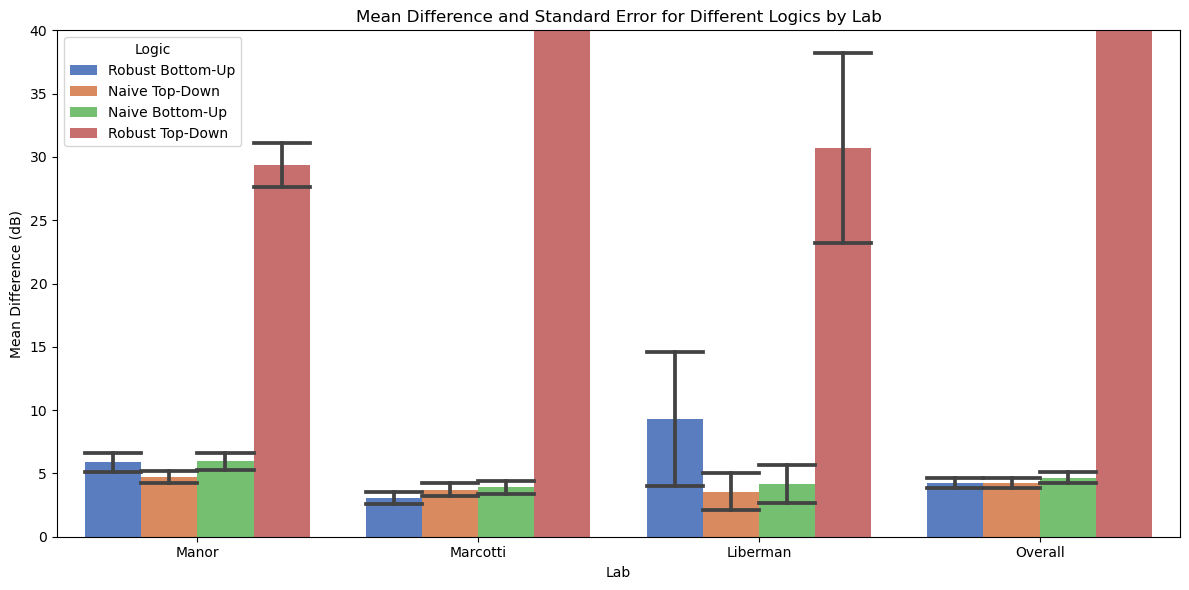

In [61]:
import seaborn as sns

# Create the plot
plt.figure(figsize=(12, 6))

# Using seaborn barplot with estimator set to mean and ci for standard error
sns.barplot(
    data=thresholds,
    x='Lab',
    y='diff',
    hue='Logic',
    estimator=np.mean,      # Use mean as the estimator
    errorbar='se',                # Show standard error
    palette='muted',
    capsize=0.2             # Add caps to error bars
)

# Customize the plot
plt.title('Mean Difference and Standard Error for Different Logics by Lab')
plt.xlabel('Lab')
plt.ylabel('Mean Difference (dB)')
plt.legend(title='Logic')
plt.tight_layout()
plt.ylim(top=40)

# Show the plot
plt.show()

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


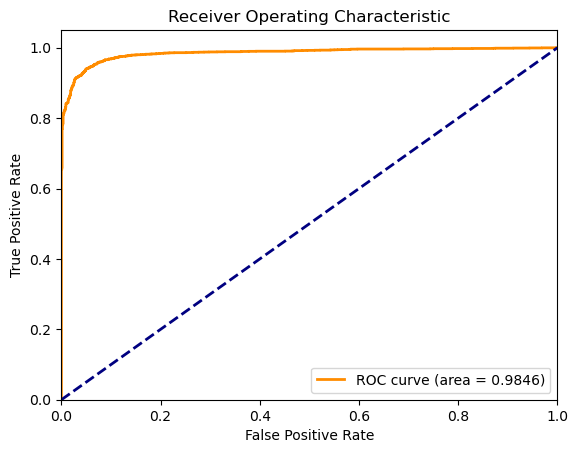

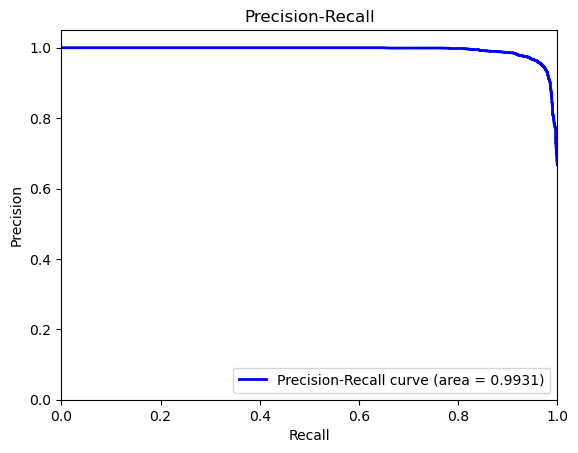

In [62]:
y_pred_probs = model.predict(X_test_cnn)

# Remove or replace NaN values
y_test = np.nan_to_num(y_test)
y_pred_probs = np.nan_to_num(y_pred_probs)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and AUC-PR
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
pr_auc = auc(recall, precision)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.4f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall')
plt.legend(loc="lower right")
plt.show()


In [32]:
import itertools

# Define parameter grid for augmentations
param_grid = {
    'noise_percentage': np.linspace(0.00001, 0.6, 31),
    'time_warp_sigma': np.linspace(0.2, 3.0, 29),
    'shift_max': range(17,35)
}

def apply_augmentations(data, noise_percentage, time_warp_sigma, shift_max):
    augmented_data = add_noise(data, noise_percentage=noise_percentage)
    augmented_data = time_warp(augmented_data, sigma=time_warp_sigma)
    augmented_data = time_shift(augmented_data, shift_max=shift_max)
    return augmented_data

In [24]:
X_liberman_test = liberman_data.drop(columns=['Hearing', 'filename', 'file_freq', 'Freq(Hz)', 'Level(dB)'])
X_liberman_test_cnn = np.expand_dims(X_liberman_test.values, axis=2)
y_liberman_test = np.array(liberman_data['Hearing'])

In [33]:
# Initialize best parameters and accuracy
best_accuracy = 0
best_params = None
results = []
used_combinations = set()

# Randomly sample parameter combinations
for i in range(200):
    while True:
        # Randomly sample parameters
        noise_percentage = np.random.choice(param_grid['noise_percentage'])
        time_warp_sigma = np.random.choice(param_grid['time_warp_sigma'])
        shift_max = np.random.choice(param_grid['shift_max'])

        # Create a tuple of parameters to check uniqueness
        params = (noise_percentage, time_warp_sigma, shift_max)

        # Check if the combination is unique
        if params not in used_combinations:
            used_combinations.add(params)
            break
    print(f'{i+1}/200: Noise %: {noise_percentage * 100}, Time Warping Sigma: {time_warp_sigma}, Max Shift: {shift_max}')

    # Apply augmentations
    augmented_X_train = apply_augmentations(
        X_train_cnn,
        noise_percentage=noise_percentage,
        time_warp_sigma=time_warp_sigma,
        shift_max=shift_max
    )

    # Combine original and augmented data
    X_train_augmented = np.concatenate((X_train_cnn, augmented_X_train), axis=0)
    y_train_augmented = np.concatenate((y_train, y_train), axis=0)
    # Define early stopping criteria
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    # Define model architecture
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters=16, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_augmented, y_train_augmented, epochs=100, verbose=0, callbacks=[early_stopping], validation_split=0.2, sample_weight=sample_weights)

    # Evaluate on the validation set
    y_pred_test = (model.predict(X_test_cnn) > 0.5).astype(int).flatten()
    accuracy = accuracy_score(y_test, y_pred_test)

    # Store the results
    results.append({
        'noise_percentage': noise_percentage,
        'time_warp_sigma': time_warp_sigma,
        'shift_max': shift_max,
        'accuracy': accuracy
    })
    print(f'Accuracy: {accuracy:4f}')

    # Update best parameters if current accuracy is higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = (noise_percentage, time_warp_sigma, shift_max)

# Print the best parameters and accuracy
print(f"Best Parameters: Noise % = {best_params[0]}, Time Warp Sigma = {best_params[1]}, Shift Max = {best_params[2]}")
print(f"Best Validation Accuracy: {best_accuracy}")

1/200: Noise %: 2.000966666666667, Time Warping Sigma: 2.8, Max Shift: 34
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.949751
2/200: Noise %: 22.000633333333337, Time Warping Sigma: 0.6, Max Shift: 30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.951109
3/200: Noise %: 8.000866666666667, Time Warping Sigma: 0.5, Max Shift: 18
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.953373
4/200: Noise %: 38.00036666666667, Time Warping Sigma: 2.9, Max Shift: 21
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.953146
5/200: Noise %: 22.000633333333337, Time Warping Sigma: 1.0999999999999999, Max Shift: 25
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.955183
6/200: Noise %: 48.00020000000001, Time Warping Sigma: 2.1, Max Shift: 20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy: 0.953146
7/200: Noise %: 28.000533333333337, Time Warping Sigma: 2.7, Max Shift: 31
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.953599
8/200: Noise %: 8.000866666666667, Time Warp

In [36]:
import plotly.graph_objects as go

# Extract parameters and accuracies for plotting
noise_percentages = [r['noise_percentage'] for r in results]
time_warp_sigmas = [r['time_warp_sigma'] for r in results]
shift_maxes = [r['shift_max'] for r in results]
accuracies = [r['accuracy'] for r in results]

# Bubble sizes proportional to accuracy - 0.8 (shifted for better scaling)
bubble_sizes = [(acc - 0.80) * 100 for acc in accuracies]

# Create a 3D scatter plot using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=noise_percentages,
    y=time_warp_sigmas,
    z=shift_maxes,
    mode='markers',
    marker=dict(
        size=bubble_sizes,
        color=accuracies,                # Set color to the accuracy values
        colorscale='Viridis',            # Choose a colorscale
        colorbar=dict(title='Accuracy'), # Show color scale
        opacity=0.8,
    ),
    text=[f'Accuracy: {acc:.4f}' for acc in accuracies]  # Hover text
))

# Set titles and labels
fig.update_layout(
    scene=dict(
        xaxis_title='Noise Percentage',
        yaxis_title='Time Warp Sigma',
        zaxis_title='Shift Max'
    ),
    title='3D Bubble Plot of Augmentation Parameters and Validation Accuracy'
)

# Show the figure
fig.show()

In [ ]:
import seaborn as sns

# Create the plot
plt.figure(figsize=(12, 6))

# Using seaborn barplot with estimator set to mean and ci for standard error
sns.barplot(
    data=thresholds,
    x='Lab',
    y='diff',
    hue='Logic',
    estimator=np.mean,      # Use mean as the estimator
    errorbar='se',                # Show standard error
    palette='muted',
    capsize=0.2             # Add caps to error bars
)

# Customize the plot
plt.title('Mean Difference and Standard Error for Different Logics by Lab')
plt.xlabel('Lab')
plt.ylabel('Mean Difference (dB)')
plt.legend(title='Logic')
plt.tight_layout()
plt.ylim(top=20)

# Show the plot
plt.show()